# Reinforcement learning basics
**Reinforcement learning (RL)** is a branch of machine learning where an **agent** learns to make decisions by interacting with an **environment**. It's inspired by how humans and animals learn from trial and error, by taking actions and receiving feedback. In this notebook, we'll introduce the key concepts of reinforcement learning, and apply them to a simple problem.

## Agent-Environment interaction
We try to frame most RL problems in this format. At each timestep **t** the **agent** receives observation $ O $ which is some representation of environment's **state** $ S_t \in \mathit{S}$ and on that basis it selects an **action** $ A_t \in \mathit{A(s)} $. One time step later, in part as a consequence of its action, the agent receives a numerical reward, $ R_{t+1} \in \mathit{R} \sub \mathbb{R} $ , and finds itself in a new state $ S_{t+1} $, together thereby give rise to a sequence or **trajectory** (or *history*) that begins like this: $ S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \ldots $

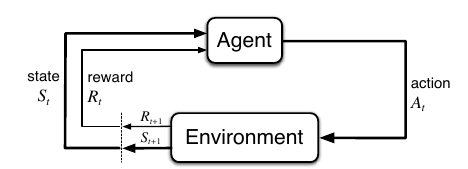

In a finite problem the sets $\mathit{S}$, $\mathit{A}$ and $\mathit{R}$ have finite number of elements.

### Example of finite environment
One of the simplest environments available in **Gymnasium** framework is **[Frozen Lake (click to read documentation)](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)**.


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 5)

def render(env: gym.Env, ax=None):
    """Helper function to render the game frame."""
    frame = env.render()
    assert frame is not None
    if ax is not None:
        ax.imshow(frame)
        ax.axis('off')
        return
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

from matplotlib.table import Table

def visualize_table(table_data, title=None, colors=None, ncols=4, nrows=4, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax=ax, bbox=[0, 0, 1, 1])

    width, height = 1.0 / ncols, 1.0 / nrows

    for i in range(len(table_data)):
        x = i % ncols
        y = i // nrows
        facecolor = colors[i] if colors else "white"
        tb.add_cell(y, x, width, height, text=table_data[i], loc="center", facecolor=facecolor)

    ax.add_table(tb)
    if title:
        ax.set_title(title)

Let's initialize the Frozen Lake environment. We will load 4x4 grid and visualize it. The goal of this game is to reach the present and not fall into the frozen lake.

In [ ]:
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False,
    render_mode='rgb_array'
)

print("S: ", env.observation_space)
print("A: ", env.action_space)
print("R: ", env.reward_range)

O, info = env.reset()

print("Observation: ", O)
render(env)
COLORS = ["white"] * 16
COLORS[0] = "green"
COLORS[15] = "red"
COLORS[5] = COLORS[7] = COLORS[11] = COLORS[12] = "gray"

visualize_table(range(16), "State Space", COLORS)

As you can see this is a **finite** environment
- State set ($S$) has 16 members (and 5 of them are **terminal** states)
- Action set ($A$) has 4 members (left, down, right, up)
- Reward set has ($R$) 2 members (1 for reaching the present and 0 for every other move)

In this case the environment is a **fully observable** one (observation is equivalent to the state), *however keep in mind that agent doesn't see the board as we do (from the bird view) but only observes on which tile it currently is, if he received reward and if it is a terminal state. The rendering of the board is just for visualization purposes.*

Let's see what happens when we take actions in the environment.

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
ARROWS = ["←", "↓", "→", "↑"]
TERMINAL = set([5, 7, 11, 12, 15])
NONTERMINAL = set(range(16)) - TERMINAL

S1, R1, T1, _, I1 = env.step(RIGHT)
print("Observation/State S1: ", S1)
print("Reward R1: ", R1)
print("Is terminal T1: ", T1)

render(env)

As you can see that after taking action $ A_0 = right $ we received the reward $ R_1 = 0 $ and the observation $S_1 = 1$. We also received the information that we are not in a terminal state yet and that this transition had probability of 1 (we are in a **deterministic** environment).

In [ ]:
S2, R2, T2, _, I2 = env.step(RIGHT)
print("Observation/State S2: ", S2)
print("Reward R2: ", R2)
print("Is terminal T2: ", T2)
render(env)

This time after taking action $ A_1 = down $ we received the reward $ R_2 = 0 $ and the observation $S_2 = 5$ but this time we found ourselves in a terminal state as we have fallen into the lake. 

This is the end of the **episode** with **trajectory** of $ S_0, A_0, R_1, S_1, A_1, R_2, S_2 = 0, right,0,1,down,0,5 $. \
The episode length is usually denoted as **T** and in this case $ T = 2 $ and $S_T = S_2$ is a terminal state. 

Consider another **trajectory**

In [ ]:
env.reset()

actions = [DOWN, DOWN, RIGHT, RIGHT, DOWN, RIGHT]

for i, A in enumerate(actions):
    O, R, T, _, _ = env.step(A)
    print(f"A{i}: ", A)
    print(f"S{i+1}: ", O)
    print(f"R{i+1}: ", R)
    print("Is terminal: ", T)
    render(env)

Now we can observe that the agent reaches the goal in 6 steps ($T=6$ the terminal state is $S_6$), all the immediate rewards were equal to 0 except the last one $R_6 = 1$

## Markov Decision Process (MDP)

Mathematical formalization of such decision making process is called **Markov Decision Process (MDP)**. The environment is said to have the **Markov property** if the future state depends only on the current state and action, and not on the past **trajectory**. This is a very strong assumption and in practice it's often violated. It helps to simplify the problem as if we learn optimal policies for some states we can hope that it will not change in the future.

MDPs can be entirelly defined by the following function: \
$p(s', r | s, a) = Pr(S_{t+1} = s', R_{t+1} = r | S_t = s, A_t = a)$ \
In other words - *the probability of transitioning to state $s'$ and receiving reward $r$ given that we are in state $s$ and took action $a$ should be defined for all state-action pairs.*

The Frozen Lake environment was an example of a **deterministic** MDP, all probabilities were equal to 1 or 0. for example $p(1,0|0,right) = 1$ and $p(1,1|0,right) = 0$. However it is possible to enable **stochastic** transitions by setting the `is_slippery` parameter to `True` in the environment initialization. (Now there is only 1/3 chance that the agent will move in the direction it wanted and 2/3 that it will move into one of orthogonal directions)

In [ ]:
senv = gym.make(        # Let senv stand for stochastic environment
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=True,
    render_mode='rgb_array'
)

O, info = senv.reset(seed=1)

render(senv)

In [ ]:
def debug_step(env: gym.Env, A: int, t: int):
    O, R, T, _, I = env.step(A)
    print(f"A{t}: {A}, S{t+1}: {O}, R{t+1}: {R}, Terminal: {T}")
    print("Info: ", I)
    render(env)

debug_step(senv, DOWN, t=0)

As you can see we performed action $down$ but ended up in the state 1 as if we moved $right$ instead. 
$1/3$ lead to the desired state and $2/3$ lead to the orthogonal states, but we never slip into the opposite direction, this opens doors for interesting strategies, for example if we want to be sure to avoid the lake we can choose action $up$ to be sure we won't slip into it.

In [ ]:
debug_step(senv, UP, t=1)

staying in $S=1$, going back to $S=0$ or going to state $S=2$ all had the same probability (1/3) after choosing action $up$ this time we got lucky and moved closer to the goal. Have we chosen action $right$ we would have 1/3 chance of slipping down to $S=5$ and loosing

## Goals and Reward hypothesis
When training RL agent we want it to acomplish some **goal**. The goal is usually some high level objective that is not directly encoded in the environment. For example in the Frozen Lake the goal/purpose is *to reach the goal without falling into the lake*.

The **reward hypothesis** states that: \
*All of what we mean by goals and purposes can be well thought of as the maximization of the expected value of the cumulative sum of a received rewards*

### Return - G
The cumulative sum of rewards to be received after time step t is called **return** (denoted as: $G_t = R_{t+1} + R_{t+2} + \ldots + R_T$). To achieve the high level goal we need to maximize the expected return. This way agent might perform actions that in the short term are not beneficial but in the long term lead to the highest return.

*Notice that if you define the return of terminal state to 0 ($G_T = 0$) you can formulate the return recursively as: $G_t = R_{t+1} + G_{t+1}$*

#### Discounted return
In practice we often use **discounted return** where we multiply each reward by a factor $\gamma^t$ where $\gamma \in [0,1]$ is called the discount factor. 
$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots + \gamma^{T-t-1} R_T$
This makes sense as we are less likely to predict rewards long in the future than the immediate ones. \
If $\gamma = 0$ the agent will only care about the immediate reward ($G_t = R_{t+1}$) \
If $\gamma = 1$ the agent will care about all future rewards equally (*the same as undiscounted case mentioned previously*).

The discounted return can be formulated recursively as: $G_t = R_{t+1} + \gamma G_{t+1}$

### Exercise from the book
Suppose = 0.5 and the following sequence of rewards is received $R_1 = 1$,
$R_2 = 2$, $R_3 = 6$, $R_4 = 3$, and $R_5 = 2$, with $T = 5$. What are $G_0, G_1 , . . ., G_5$?

*Hint: Work backwards*

## Calculating returns

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython import display
from typing import List, Tuple, Protocol


Trajectory = List[Tuple[float, int, int]]

class Agent(Protocol):
    def act(self, state: int) -> int:
        pass


def run_episode(env: gym.Env, agent: Agent, seed=None, visualize=True, starting_state: int=0, starting_action=None) -> Trajectory:
    """Run episode following some policy, allows for displacement. """
    env.reset(seed=seed)

    # assert not starting_state in TERMINAL
    S = env.unwrapped.s = starting_state

    T = False
    R = 0.0

    frames = []
    frames.append(env.render())

    trajectory = []

    if starting_action is not None:
        trajectory.append((R, S, starting_action))
        S, R, T, _, _ = env.step(starting_action)
        frames.append(env.render())

    while not T:
        A = agent.act(S)
        trajectory.append((R, S, A))
        S, R, T, _, _ = env.step(A)
        frames.append(env.render())
    trajectory.append((R, S, None))

    if visualize:
        fig = plt.figure() 

        def animate(i):
            plt.imshow(frames[i])
            plt.axis('off')

        ani = FuncAnimation(fig, animate, frames=len(frames), interval=300, blit=False)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()

    return trajectory

In [ ]:
class HardCodedAgent(Agent):
    def __init__(self, actions: List[int]):
        self.actions = actions
        self.t = 0
    
    def act(self, state: int) -> int:    # Hard coded agent doesn't care about the state
        action = self.actions[self.t]
        self.t += 1
        return action

agent = HardCodedAgent([RIGHT, RIGHT, DOWN, DOWN, LEFT, DOWN, RIGHT, RIGHT])
trajectory = run_episode(env, agent, visualize=True)

print(trajectory)

Let's calculate how return would look like on each state of this episode. We will use multiple discount factors ($\gamma$) to see how it affects the return. 
Notice that:
- terminal state has always return of 0 as no more rewards can be received after it.
- we can only evaluate the return of the states that were visited in the episode.

In [ ]:
def evaluate_trajectory(T: Trajectory, gammas=[0, 0.5, 0.9, 1]):
    for gamma in gammas:
        G_table = [None for _ in range(16)]
        G = 0 # Terminal
        for R, S, _ in reversed(T):
            G_table[S] = G
            G = R + gamma * G

        G_table = [f"{G:.2f}" if G is not None else "" for G in G_table]
        visualize_table(G_table, f"Discounted Return (gamma={gamma})", COLORS)

evaluate_trajectory(trajectory)

Let's consider a more optimal episode, where the agent reaches the goal in a shorter amount of steps, notice that on average returns will be higher than in the longer episode, which is another useful feature of **discounting**

In [ ]:
agent = HardCodedAgent([DOWN, DOWN, RIGHT, RIGHT, DOWN, RIGHT])
trajectory = run_episode(env, agent)
evaluate_trajectory(trajectory, gammas=[0.5, 0.9])

Let's consider episode that ends in agent falling into the lake, notice that we never get any reward in such episode so all returns are equal to 0!

In [ ]:
agent = HardCodedAgent([DOWN, DOWN, RIGHT, UP])
trajectory = run_episode(env, agent)
evaluate_trajectory(trajectory)

## Policy - $\pi$
Policy (denoted as $\pi$) - is a way of acting of the agent when in certain states. It is a function that maps states to actions
- In the deterministic case: $\pi(s) = a$
- In the stochastic case: $\pi(a|s) = Pr(A_t = a | S_t = s)$.

We denote the optimal policy as $\pi^*$ and it is the policy that maximizes the expected return for all states. Finding of such a policy is the main goal of the reinforcement learning and solution of the MDP.

For now let's define some policies by hand (later we will see how to learn policies from the environment)

In [ ]:
policy = [
    RIGHT, RIGHT, DOWN,  LEFT, \
    DOWN,  -1,    DOWN,  -1, \
    RIGHT, RIGHT, DOWN,  -1, \
    -1,    RIGHT, RIGHT, -1
]

def visualize_policy(policy, colors=COLORS, ax=None):
    policy_viz = [ARROWS[A] if A != -1 and i not in TERMINAL else "" for i, A in enumerate(policy)]
    visualize_table(policy_viz, "Policy", colors=colors, ax=ax)

visualize_policy(policy)

This way we defined a **deterministic** policy. We mapped every state to a specific action, so agent can just lookup the action in the table and take it.

Let's test the policy in the environments starting from multiple different initial states.

In [ ]:
class DeterministicPolicy(Agent):
    def __init__(self, policy):
        self.policy = policy

    def act(self, S):
        return self.policy[S]

In [ ]:
starting_positions = [0, 3, 8]

agent = DeterministicPolicy(policy)

for start in starting_positions:
    run_episode(env, agent, visualize=True, starting_state=start)

Now let's see how our policy performs in the stochastic environment (with `is_slippery=True`)

In [ ]:
for seed in [0, 6, 9]:
    run_episode(senv, agent, seed=seed)

As you can see the policy which seemed to be optimal in the deterministic environment is definetly not optimal in the stochastic one.

## Policy evaluation

### State-Value function

For every policy $\pi$ we can define a value function (denoted as $v_{\pi}$) that maps states to expected returns.

$ v_{\pi}(s) = \mathbb{E}_{\pi}$[G_t | S_t = s]

In other words: $v_{\pi}(s)$ is expected discounted return when starting in s and following $\pi$ thereafter. *(t can be any timestep)*
Value function is a measure of how desirable it is to be in certain states.

Although for some MDPs it is possible to exactly calculate v, in practice we usually estimate it. Estimation of the value function is denoted as $V_{\pi}(s)$ (capital V)

### Monte carlo method
Let's try to approximate the value function for the policy we defined earlier. We will use the **Monte Carlo method**. It is a method of estimating the value function by averaging the returns that were observed after visiting the state, to achieve this we need to run multiple **sample episodes** and calculate the returns after the episode ends.

In [ ]:

def monte_carlo_V(env: gym.Env, agent: Agent, num_episodes: int=500, gamma: float=0.9, exploring_starts=False) -> tuple[list, list]:
    """Monte Carlo algorithm to estimate the value function, returns also the number of visits for each state."""
    V = [0.0 for _ in range(16)] # Set initial estimates to 0
    N = [0 for _ in range(16)]   # Number of visits for each state
    start = 0

    for _ in range(num_episodes):
        if exploring_starts:  # If set, start each episode from a random state
            start = np.random.choice(list(NONTERMINAL))

        trajectory = run_episode(env, agent, starting_state=start, visualize=False)
        G = 0
        for R, S, _ in reversed(trajectory):
            N[S] += 1
            V[S] += (G - V[S]) / N[S]
            G = R + gamma * G

    return V, N

In [ ]:
V, N = monte_carlo_V(senv, agent, num_episodes=500)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
visualize_table([f"{v:.3f}" for v in V], "Value function estimate - Vπ(s)", COLORS, ax=ax[0])
visualize_table([f"{n}" for n in N], "Number of Visits - N(s)", COLORS, ax=ax[1])

We have evaluated values of each states, here are some observations:
- observe that for every **terminal** state the value is equal to 0. This is because we can't receive any more rewards after reaching the terminal state.
- Notice that sum of numbers of visits to terminal states is equal to the number of episodes we run (2000)
- Number of visits to the initial state is higher than number of episodes due to slippery lake making agent return there sometimes.
- Only a small portion of simulations ended in reaching the present, most of them ended in falling into the lake.
- Going down in the beginning seems to be a safer option

### Exploring starts
We could obtain more accurate estimates by running simulations starting from random state and not only from the state 0 (called **exploring starts**)

In [ ]:
V, N = monte_carlo_V(senv, agent, num_episodes=500, exploring_starts=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
visualize_table([f"{v:.3f}" for v in V], "Value function estimate - Vπ(s)", COLORS, ax=axs[0])
visualize_table([f"{n}" for n in N], "Number of Visits - N(s)", COLORS, ax=axs[1])

As you can see the approximation is more precise because we sample the states more evenly. (Keep in mind that many environments don't allow for **exploring starts** and we will have to find way to explore the environment from an initial state)

In [ ]:
import random

class RandomAgent(Agent):
    def __init__(self, num_actions: int):
        self.num_actions = num_actions

    def act(self, S):
        return random.randint(0, self.num_actions - 1)

random_agent = RandomAgent(4)

V, N = monte_carlo_V(env, random_agent, num_episodes=2000, exploring_starts=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
visualize_table([f"{v:.3f}" for v in V], "Value function estimate - Vπ(s)", COLORS, ax=axs[0])
visualize_table([f"{n}" for n in N], "Number of Visits - N(s)", COLORS, ax=axs[1])

So even though our policy was not optimal, it is still better than the random one.

### State-Action-Value function
Although the state-value function is useful, it is of *limited* use in the problems where we don't have the access to the environment **model** (i.e we don't know which actions lead to which states and rewards and with what probability) only after taking the action we know what the next state will be so we cannot use state-value function to choose the best action. (In games like chess and go we know all the rules and can choose the move that leads to the most valued state)

This is where the state-action value function comes in. It is denoted as $q_{\pi}(s,a) = \mathbf{E}_{\pi}[R_{t+1} + \gamma G_{t+1} | S_t = s, A_t = a]$ and it is the expected return after taking action a in state s and then following policy $\pi$. It is clear to see that it would be much more useful in the problems where we don't have the access to the environment model, in each state we will use the action with the highest value.

In [ ]:
def monte_carlo_Q(env: gym.Env, agent: Agent, num_episodes: int=500, gamma: float=0.9, exploring_starts=False, benchmark=False) -> tuple[list, list]:
    """Monte Carlo algorithm to estimate the state-action value function"""
    Q = [[0.0 for _ in range(4)] for _ in range(env.observation_space.n)] # Set initial estimates to 0
    N = [[0   for _ in range(4)] for _ in range(env.observation_space.n)] # Number of visits for each state, action pair

    total_rewards = []  # used for benchmarking
    for _ in range(num_episodes):
        start = 0
        action = None

        if exploring_starts:
            start = np.random.randint(env.observation_space.n)
            action = np.random.randint(env.action_space.n)

        trajectory = run_episode(env, agent, visualize=False, starting_state=start, starting_action=action)
        G = 0
        for R, S, A in reversed(trajectory):
            if A is not None:
                N[S][A] += 1       # Increase the number of visits for state-action pair
                Q[S][A] += (G - Q[S][A]) / N[S][A]                 # Update the estimate
            G = R + gamma * G

        total_reward = sum([R for R, _, _ in trajectory])
        total_rewards.append(total_reward)

    if benchmark:
        return Q, N, sum(total_rewards) / num_episodes
    return Q, N

Let's try to approximate the state-action value function for the random policy (agent that always takes random actions) - this way we will eventually explore all pairs. Let's run the simulation in **deterministic** environment first (non slippery lake).

In [ ]:
Q, N  = monte_carlo_Q(env, random_agent, num_episodes=2000, exploring_starts=True)

In [ ]:
import numpy as np

def visualize_qtable(Q, ax, color_max=False, round_digits=0, title="QTable"):
    # _, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax=ax, bbox=[0, 0, 1, 1])

    NSTATES = 16
    NACTIONS = 4

    width, height = 1.0 / (NACTIONS + 1), 1.0 / (NSTATES + 1)

    for s in range(NSTATES):
        tb.add_cell(s+1, 0, width, height, text=f"S{s}", loc="center", facecolor="gray")
        argmax = np.argmax(Q[s])
        for a in range(NACTIONS):
            if s in TERMINAL:
                tb.add_cell(s+1, a+1, width, height, text="", loc="center", facecolor="#ccc")
                continue
            x = a
            y = s
            facecolor = "white"
            if a == argmax and color_max:
                facecolor = "green"
            if round_digits:
                text = f"{Q[s][a]:.{round_digits}f}"
            else:
                text = f"{Q[s][a]}"
            tb.add_cell(y+1, x+1, width, height, text=text, loc="center", facecolor=facecolor)

    for a in range(NACTIONS):
        tb.add_cell(0, a+1, width, height, text=ARROWS[a], loc="center", facecolor="gray")

    ax.add_table(tb)
    ax.set_title(title)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  

env.reset()
render(env, axs[0])
visualize_qtable(Q, axs[1], True, 4)
visualize_qtable(N, axs[2], False, 0, "Number of Visits")

policy = np.argmax(Q, axis=1)
policy_arrows = [ARROWS[a] for a in policy]
for s in TERMINAL: policy_arrows[s] = ""

visualize_table(policy_arrows, "New Policy (greedy with respect to Q)", COLORS, ncols=4, nrows=4, ax=axs[3])

As you can see the Q table is larger than V table. Q table will be much more useful as it stores more information useful for decision making (control problems).

For the sake of theory let's show that it is easy to calculate the V function from Q function. \
$ v_{\pi}(s) = \sum_{a \in \mathit{A}} \pi(a|s) q_{\pi}(s,a)$

We chose $\pi$ to be an uniform policy so $\pi(a|s) = \frac 1 {|\mathit{A}|}  = \frac1 4$ for all actions in each state. \
So the equation simplifies to average of state-action values in each state (mean of each row):

Let's see if this is really the case by checking if the V table approximated previously is the same as V calculated from averages in Q table:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
visualize_table([f"{s:.3f}" for s in V], "direct approx of V", COLORS, ax=ax[0])

Q_sums = np.mean(Q, axis=1)
visualize_table([f"{s:.3f}" for s in Q_sums], "V from approx of Q", COLORS, ax=ax[1])

It is indeed the case, the V table is similiar to the one we approximated previously (in the limit it would be exactly the same).

Notice that we can also calculate the q function from the v function, but it requires the access to the environment model. \
$ q_{\pi}(s,a) = \sum_{s' \in \mathit{S}, r \in \mathit{R}} p(s',r|s,a) [r + \gamma v_{\pi}(s')]$ - where p models dynamics of the environment

## Policy improvement
We know how to evaluate the policy, the question is how can we improve it? We can do it by using the value function to choose the best action in each state. This way we can define a new policy that is **greedy** with respect to the **value** function. This way we can guarantee that the new policy will be at least as good as the old one.

After calculating new value table for a better policy, all entries should be higher or equal than corresponding values in the old value table. This is called **policy improvement theorem**.

Let's try to evaluate the improved policy (greedy with respect to the value function - see previous visualization) and see if it yields higher returns. (We are not using exploring starts here)

In [ ]:
def evaluate_and_visualize(env, agent, num_episodes=1000, exploring_starts=False):
    Q, NQ = monte_carlo_Q(env, agent, num_episodes=num_episodes, exploring_starts=exploring_starts)
    V, N = monte_carlo_V(env, agent, num_episodes=num_episodes, exploring_starts=exploring_starts)

    _, axs = plt.subplots(1, 4, figsize=(20, 5))

    visualize_qtable(Q, axs[0], True, 4)
    visualize_qtable(NQ, axs[1])
    visualize_table([f"{v:.3f}" for v in V], "Value function estimate - Vπ(s)", COLORS, ax=axs[2])
    visualize_table([f"{n}" for n in N], "Number of Visits - N(s)", COLORS, ax=axs[3])

policy = np.argmax(Q, axis=1)
new_agent = DeterministicPolicy(policy)
evaluate_and_visualize(env, new_agent, num_episodes=500)

Notice that the new policy is indeed better (in fact it is optimal) however we have a problem with evaluating it. The problem is that the greedy policy is fixed and unable to explore other states than the ones it already knows (it is **exploiting** the knowledge). This is called **exploitation-exploration dilemma**. We need to explore other states to be sure that the policy is indeed optimal. (what happens iw we are dropped in the upper right corner? Is the policy still optimal?)

One solution would be to use **exploring starts**:

In [ ]:
evaluate_and_visualize(env, new_agent, num_episodes=1000, exploring_starts=True)

Indeed we can see that the value is approximated now for all states and state-action pairs. We also see that the policy is better than the random one.

Another way would be to use **$\epsilon$-greedy** policy, it is a way of action where with probability $\epsilon$ we take a **random** action and with probability $1-\epsilon$ we take the **greedy** action. This way we can **explore** other states and still **exploit** the knowledge we already have. 

*(see more in the bandits.ipynb notebook)*

In [ ]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, policy, epsilon=0.1):
        self.pi = policy
        self.epsilon = epsilon

    def act(self, S):
        if random.random() < self.epsilon:
            return (policy[S] + random.randint(1, 3)) % 4   # Random action different from the greedy one
        return policy[S]

egreedy_agent = EpsilonGreedyAgent(policy, epsilon=0.1)

evaluate_and_visualize(env, egreedy_agent, num_episodes=2000)

Having changed the policy from greedy to epsilon greedy we were able to evaluate every position, but of course the visits weren't as balanced in the idelized (**exploring starts**) case. 

### Generalized policy iteration (GPI)
The process of iteratively evaluating and improving the policy is called **generalized policy iteration**. It is a general concept that can be used to solve MDPs. It is guaranteed to converge to the optimal policy if we perform both steps infinitely many times. Let's run the GPI algorithm on slippery FrozenLake environment.

Similarily as before we will start with a random agent:

In [ ]:
def policy_evaluation(env, agent, num_episodes, visualize=True):
    Q, _, avg_total_reward = monte_carlo_Q(env, agent, num_episodes=num_episodes, exploring_starts=True, benchmark=True)

    if visualize:
        fig, ax = plt.subplots()
        visualize_qtable(Q, ax, True, 4, "Qπ(s, a)")

    return Q, avg_total_reward

In [ ]:
Q0, TR0 = policy_evaluation(senv, random_agent, num_episodes=1000, visualize=True)

Now let's improve the policy greedily with respect to the value function and evaluate it again:

In [ ]:
policy1 = np.argmax(Q0, axis=1)
agent1 = DeterministicPolicy(policy1)

visualize_policy(policy)

This is one iteration of GPI done, now let's do another one staring by evaluating the new policy:

In [ ]:
Q1, TR1 = policy_evaluation(senv, agent1, num_episodes=1000, visualize=True)

In [ ]:
policy2 = np.argmax(Q1, axis=1)
agent2 = DeterministicPolicy(policy2)

visualize_policy(policy2)

In [ ]:
def benchmark_agent(env, agent, num_iters=500):
    rewards = []
    for _ in range(num_iters):
        trajectory = run_episode(env, agent, visualize=False)
        rewards.append(sum([R for R, _, _ in trajectory]))
    return sum(rewards) / len(rewards)

print("Random Agent: ", benchmark_agent(senv, random_agent))
print("Policy Agent 1: ", benchmark_agent(senv, agent1))
print("Policy Agent 2: ", benchmark_agent(senv, agent2))
print("Policy Agent 3: ", benchmark_agent(senv, agent3))

Let's implement the GPI algorithm and try to run it on a larger FrozenLake

In [ ]:
def GPI(env, num_episodes, iterations=5):
    agent = RandomAgent(4)

    Vs = []
    Ps = []

    for i in range(iterations):
        print(f"{i} - iteration")
        print("\tEvaluating policy")
        Q = policy_evaluation(env, agent, num_episodes, visualize=False)

        V = np.mean(Q, axis=1)
        Vs.append(V)

        print("\tImproving policy")
        policy = np.argmax(Q, axis=1)

        Ps.append(policy)

        agent = DeterministicPolicy(policy)

    _, axs = plt.subplots(2, iterations, figsize=(5 * iterations, 5))
    for i, v in enumerate(Vs):
        visualize_table([f"{s:.3f}" for s in v], "Vπ(s)", ax=axs[0][i])
        visualize_policy(Ps[i], ax=axs[1][i], colors=None)

    return agent

In [ ]:
big_env = gym.make(
    'FrozenLake-v1',
    map_name="8x8", 
    is_slippery=True,
    render_mode='rgb_array'
)

GPI(big_env, 100, iterations=3)

## TODO:

- Value
- Bellman equation
- Generalized policy iteration
- Monte carlo vs Temporal difference

Bibliography:
- Reinforcement Learning An Introduction (2nd edition) - Richard Sutton and Andrew Barto
- Gymnasium framework (https://gymnasium.farama.org/)